Status Code: 200

- H0(귀무가설): 데이터는 정규분포를 따른다.
- H1(대립가설): 데이터는 정규분포를 따르지 않는다.

Phase 1 - Shapiro-Wilk Test: Statistics=0.9758254885673523, p-value=3.55269767169375e-05
Phase 1 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)
Phase 1 - Bin Width: 11428.57142857143
Phase 2 - Shapiro-Wilk Test: Statistics=0.9496108889579773, p-value=6.77806211157872e-09
Phase 2 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)
Phase 2 - Bin Width: 6284.880103359173
Phase 3 - Shapiro-Wilk Test: Statistics=0.9533681869506836, p-value=2.1994658538915246e-08
Phase 3 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)
Phase 3 - Bin Width: 3764.0072425259727
Phase 4 - Shapiro-Wilk Test: Statistics=0.9053189754486084, p-value=5.888870120707157e-13
Phase 4 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)
Phase 4 - Bin Width: 2254.286595077862
Phase 5 - Shapiro-Wilk Test: Statistics=0.8417379856109619, p-value=1.2064172477223772e-16
Phase 5 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)
Phase 5 - Bin Width: 1463.725469884196
Phase 6 - Shapiro-Wilk Test: Statistics=0.772720217704773, p-value=5.03600429920

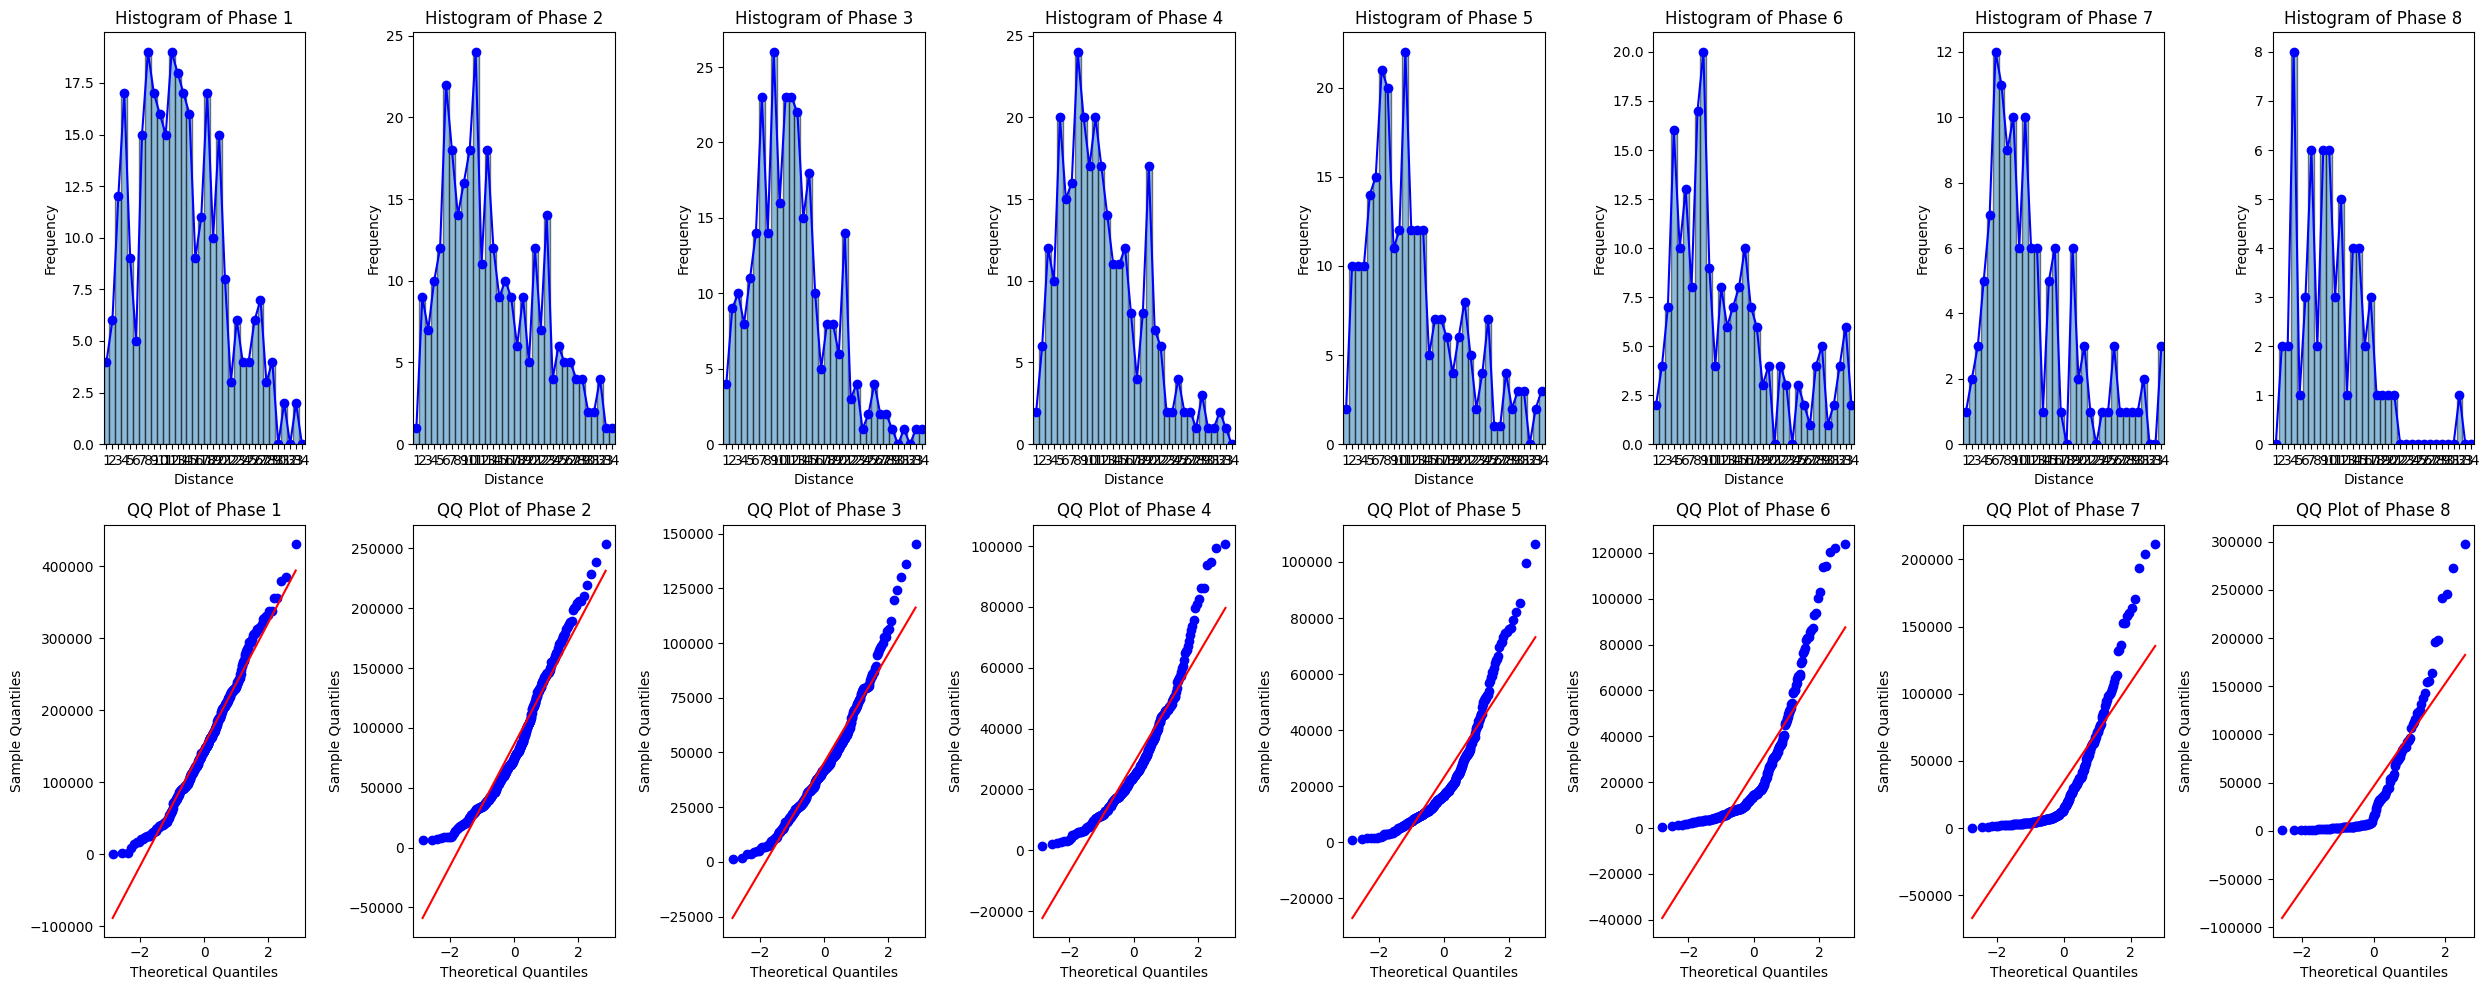


- H0(귀무가설): 살아있는 유저들의 위치와 자기장 중심의 위치는 무관하다. 즉, 자기장은 무작위로 잡힌다.
- H1(대립가설): 살아있는 유저들의 위치가 자기장 중심의 위치에 영향을 미친다. 즉, 자기장은 살아있는 유저들의 위치를 고려하여 잡힌다.

Phase 1 - 스피어만 상관분석: 상관계수=-0.6442989188030902, p-value=3.921299234612295e-05
Phase 2 - 스피어만 상관분석: 상관계수=-0.638059705587189, p-value=4.9153769946730106e-05
Phase 3 - 스피어만 상관분석: 상관계수=-0.7516899763789939, p-value=2.9908814961123705e-07
Phase 4 - 스피어만 상관분석: 상관계수=-0.7328187985825596, p-value=8.308020138281618e-07
Phase 5 - 스피어만 상관분석: 상관계수=-0.7309817328497219, p-value=9.135314015475107e-07
Phase 6 - 스피어만 상관분석: 상관계수=-0.6014198186863474, p-value=0.00016859379414703335
Phase 7 - 스피어만 상관분석: 상관계수=-0.5909637013927217, p-value=0.00023326709547595435
Phase 8 - 스피어만 상관분석: 상관계수=-0.7006037456435822, p-value=3.9598520616432805e-06

- H0(귀무가설): 살아있는 유저들의 위치와 자기장 중심의 위치는 무관하다. 즉, 자기장은 무작위로 잡힌다.
- H1(대립가설): 살아있는 유저들의 위치가 자기장 중심의 위치에 영향을 미친다. 즉, 자기장은 살아있는 유저들의 위치를 고려하여 잡힌다.



In [14]:
import requests
import matplotlib.pyplot as plt
from scipy.stats import shapiro, spearmanr, probplot
import numpy as np

# GET 요청을 보낼 기본 URL
base_url = 'http://192.168.0.79:5000'
endpoints = "/whitezoneAnalysis/phases"
header = {
    "Accept": "application/json"
}

# GET 요청 보내기
get_response = requests.get(url=base_url + endpoints, headers=header)

# 응답 상태 코드 확인
print('Status Code:', get_response.status_code)

# 응답 데이터 출력
if get_response.status_code == 200:
    data = get_response.json()
else:
    print('Failed to retrieve data')
    data = {}

# 거리 리스트 초기화
distance_list = []
phase_coordinates = []

for i in range(len(data)):
    phase_list = []
    coordinates_list = []
    phase_key = f"Phase{i+1}"
    if phase_key in data:
        for j in range(len(data[phase_key])):
            x1 = data[phase_key][j]["user_geometry_center_x"]
            x2 = data[phase_key][j]["white_zone_center_x"]
            y1 = data[phase_key][j]["user_geometry_center_y"]
            y2 = data[phase_key][j]["white_zone_center_y"]
            distance = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            phase_list.append(distance)
            coordinates_list.append((x1, y1, x2, y2))
        distance_list.append(phase_list)  # 반복문 밖으로 이동
        phase_coordinates.append(coordinates_list)

# 이상치 제거 함수 (상한치만 고려)
def remove_upper_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    upper_bound = Q3 + 3.5 * IQR
    return [x for x in data if x <= upper_bound]

# 초기 x축 끝값 설정 및 페이즈별 줄어드는 비율
x_end_values = [400000, 219970.803617571057, 131740.25348840904, 78900.030827725155, 51230.391445946857, 33270.6639480441026, 21600.2976675614, 15100.0693623677593]

# 각 페이즈별로 샤피로-윌크 검정 수행 및 히스토그램 시각화
num_phases = len(distance_list)
fig, axes = plt.subplots(2, num_phases, figsize=(25, 10))

# 상관분석 결과 저장
# 가설 설명
print("""
- H0(귀무가설): 데이터는 정규분포를 따른다.
- H1(대립가설): 데이터는 정규분포를 따르지 않는다.
""")
correlation_results = []

for i in range(num_phases):
    specific_phase = remove_upper_outliers(distance_list[i])  # 상한치만 고려하여 이상치 제거
    
    # 샤피로-윌크 검정
    stat, p_value = shapiro(specific_phase)
    print(f'Phase {i+1} - Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')
    if p_value > 0.05:
        print(f'Phase {i+1} 데이터는 정규 분포를 따릅니다 (귀무가설 기각 실패)')
    else:
        print(f'Phase {i+1} 데이터는 정규 분포를 따르지 않습니다 (귀무가설 기각)')

    # 히스토그램 그리기
    x_end = x_end_values[i]
    bins = np.linspace(0, x_end, 35)  # 35개의 bin으로 나누기
    
    counts, bins, _ = axes[0, i].hist(specific_phase, bins=bins, edgecolor='black', alpha=0.5)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    axes[0, i].plot(bin_centers, counts, linestyle='-', marker='o', color='blue')
    axes[0, i].set_title(f'Histogram of Phase {i+1}')
    axes[0, i].set_xlabel('Distance')
    axes[0, i].set_ylabel('Frequency')
    axes[0, i].set_xlim(0, x_end)
    
    # x축 라벨링 변경
    locator = plt.FixedLocator(bin_centers)
    labels = [str(idx + 1) for idx in range(len(bin_centers))]
    formatter = plt.FixedFormatter(labels)
    axes[0, i].xaxis.set_major_locator(locator)
    axes[0, i].xaxis.set_major_formatter(formatter)
    
    # bin_width 출력
    print(f"Phase {i+1} - Bin Width: {x_end / 35}")

    # QQ 플롯 생성
    probplot(specific_phase, dist="norm", plot=axes[1, i])
    axes[1, i].set_title(f'QQ Plot of Phase {i+1}')
    axes[1, i].set_xlabel('Theoretical Quantiles')
    axes[1, i].set_ylabel('Sample Quantiles')
    
    
    # 스피어만 상관분석
    corr, p_value = spearmanr(bin_centers, counts)
    correlation_results.append((i + 1, corr, p_value))

plt.tight_layout()
plt.show()

# 가설 설명
print("""
- H0(귀무가설): 살아있는 유저들의 위치와 자기장 중심의 위치는 무관하다. 즉, 자기장은 무작위로 잡힌다.
- H1(대립가설): 살아있는 유저들의 위치가 자기장 중심의 위치에 영향을 미친다. 즉, 자기장은 살아있는 유저들의 위치를 고려하여 잡힌다.
""")
# 스피어만 상관분석 결과 출력
for result in correlation_results:
    phase, corr, p_value = result
    print(f'Phase {phase} - 스피어만 상관분석: 상관계수={corr}, p-value={p_value}')

